In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

/Users/blaiseappolinary/miniconda3/envs/cv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("data/heart.csv")
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


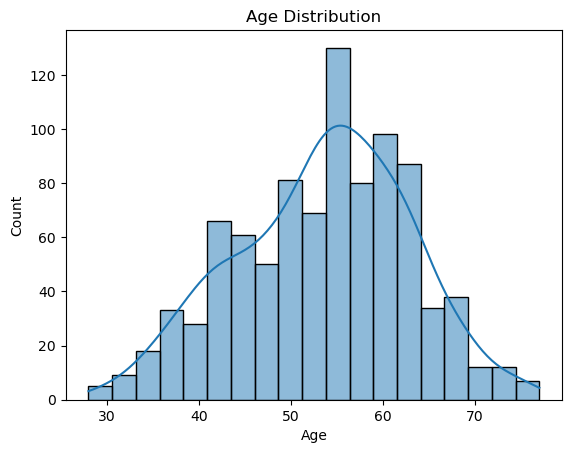

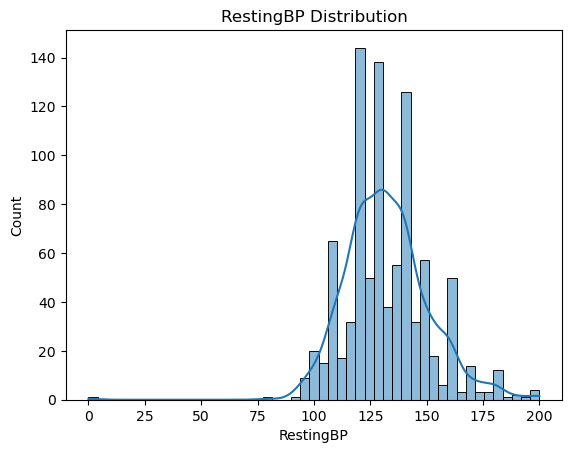

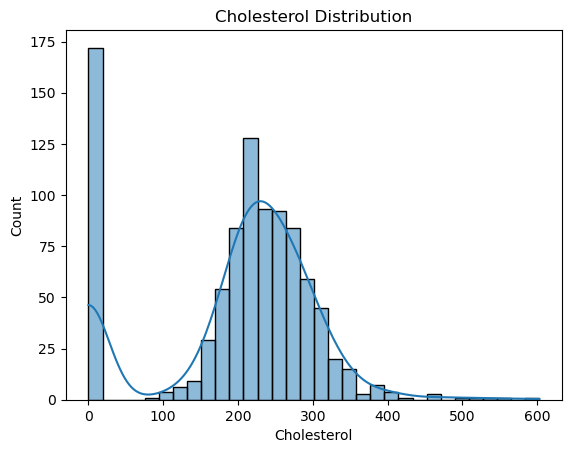

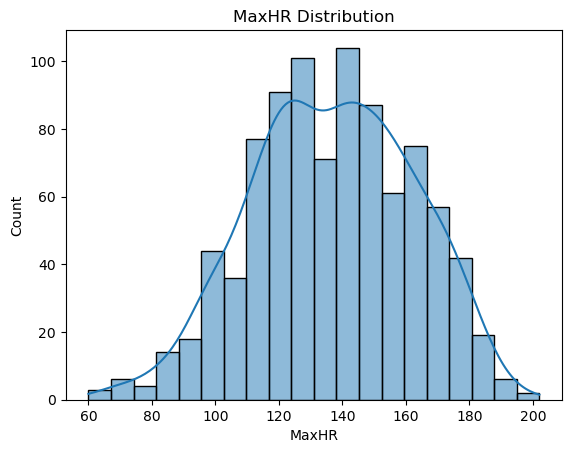

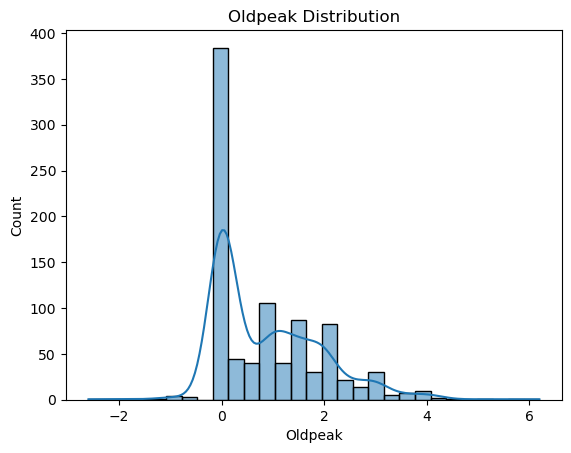

In [4]:
numerical_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
for col in numerical_columns:
    plt.figure()
    sns.histplot(data[col], kde=True)
    plt.title(f'{col} Distribution')

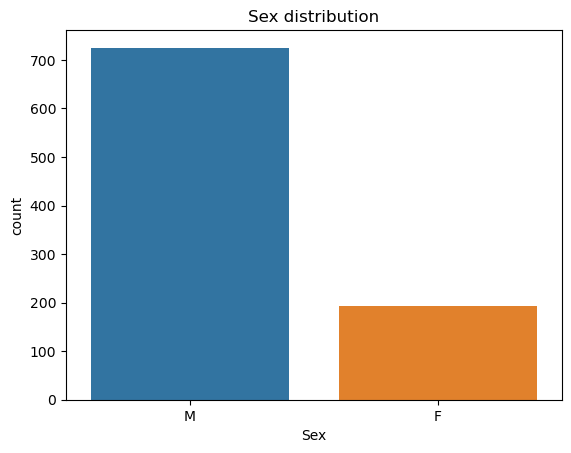

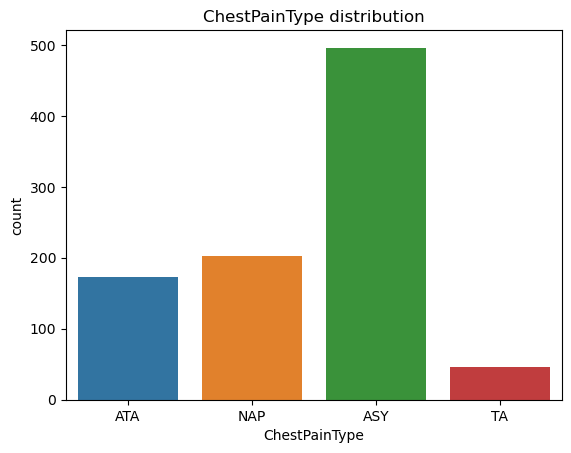

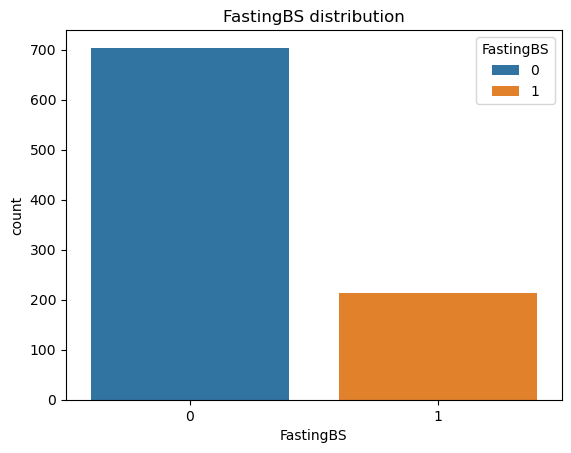

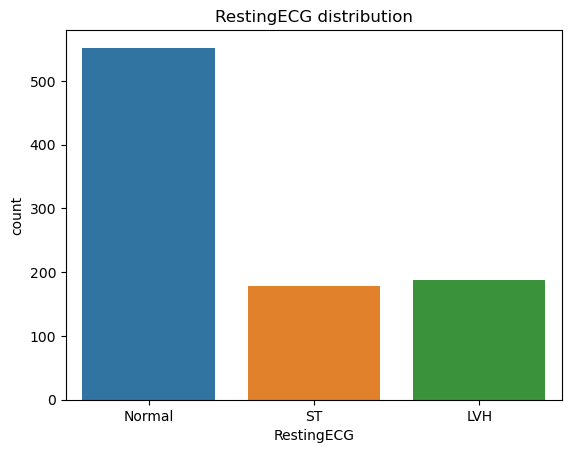

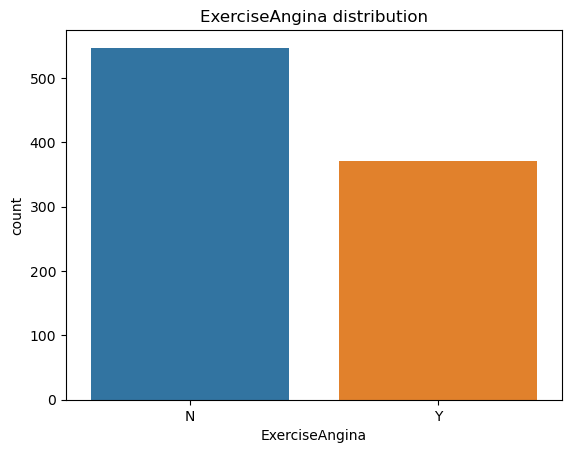

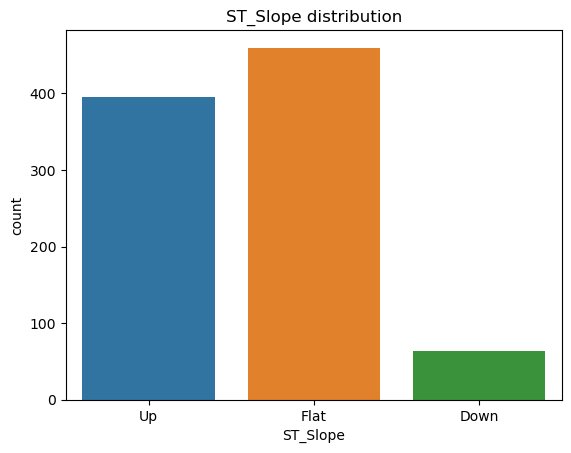

In [5]:
categorical_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

for col in categorical_cols:
    plt.figure()
    sns.countplot(data=data, x=col, hue=col)
    plt.title(f'{col} distribution')


**Bivariate Analysis**

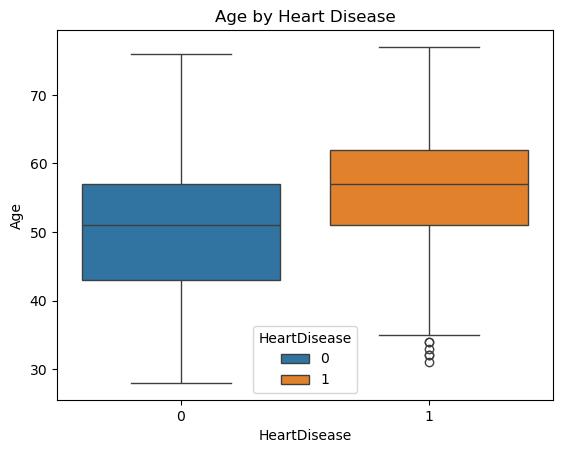

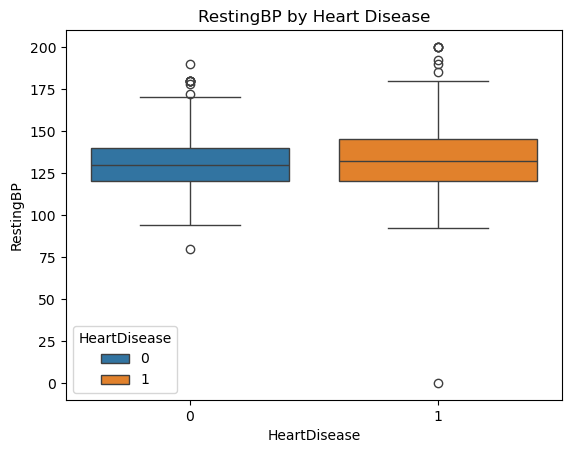

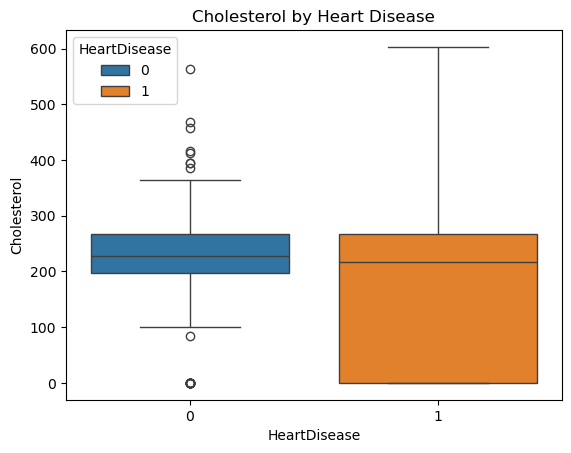

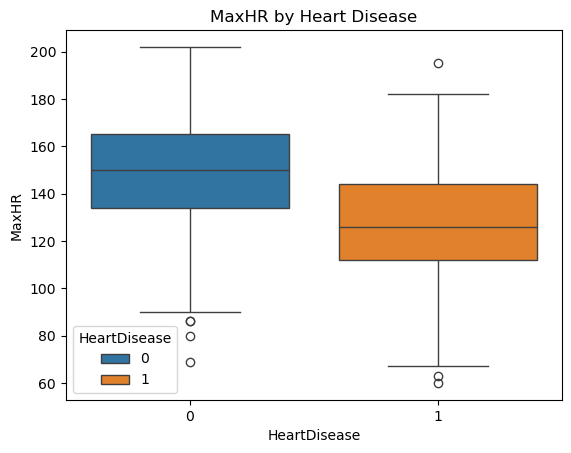

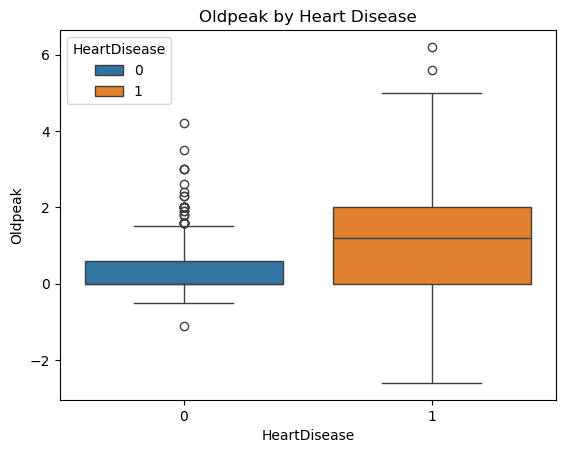

In [6]:
for col in numerical_columns:
    plt.figure()
    sns.boxplot(data=data, x='HeartDisease', y=col, hue='HeartDisease')
    plt.title(f'{col} by Heart Disease')

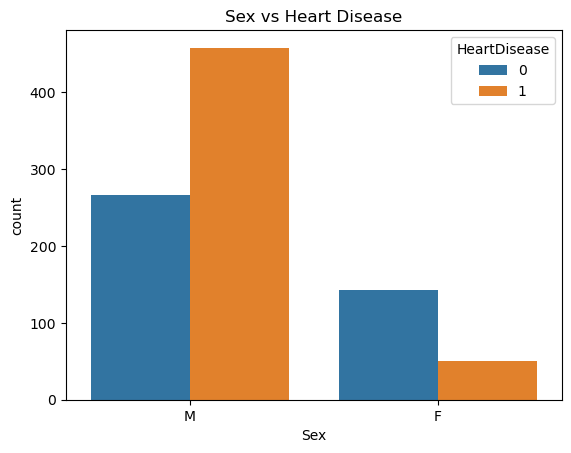

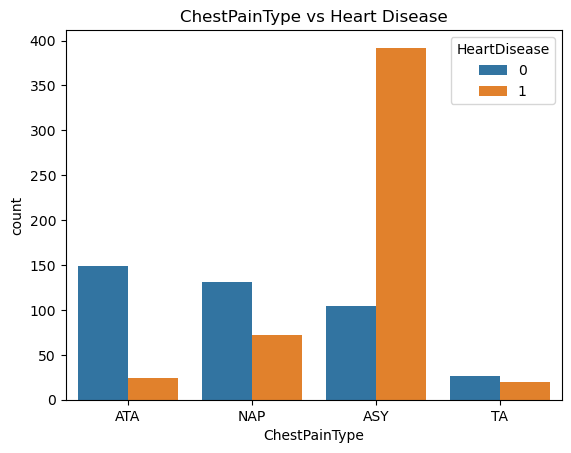

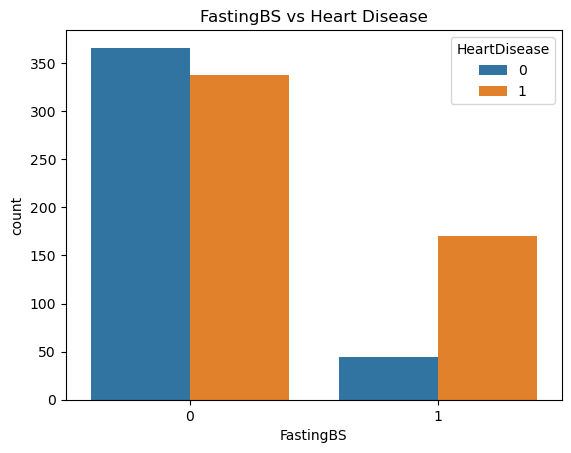

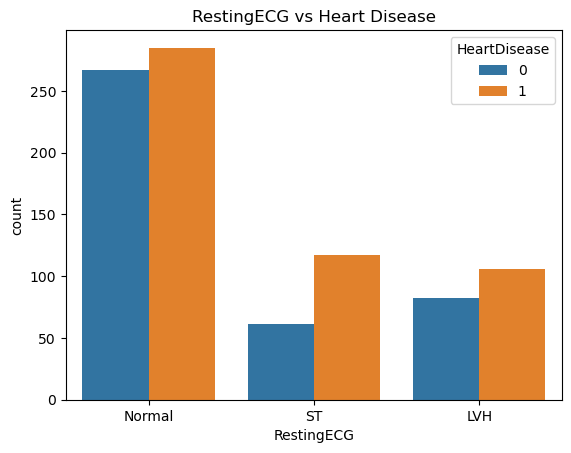

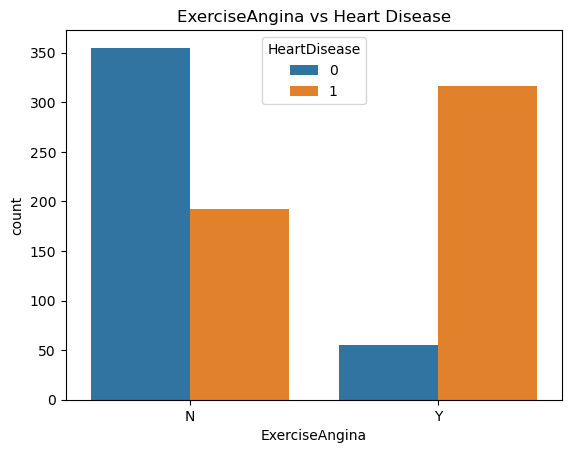

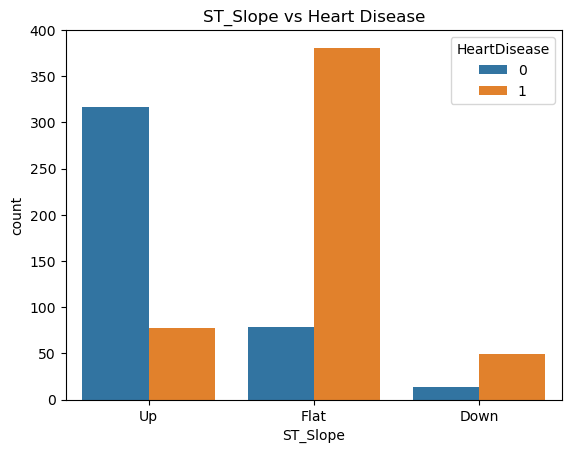

In [7]:
for col in categorical_cols:
    plt.figure()
    sns.countplot(data=data, x=col, hue='HeartDisease')
    plt.title(f'{col} vs Heart Disease')


**HeatMap**

Text(0.5, 1.0, 'Correlation Heatmap')

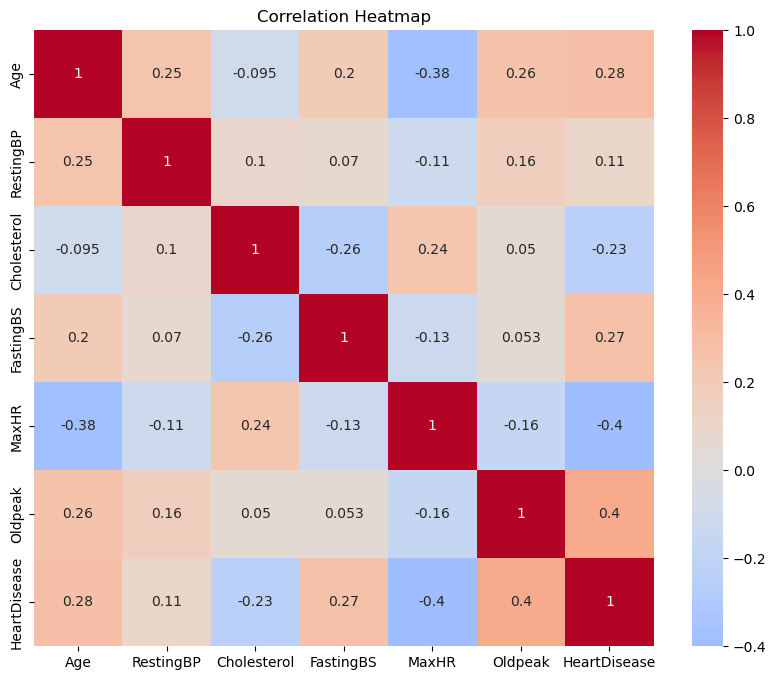

In [8]:
plt.figure(figsize=(10,8))
corr = data.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')


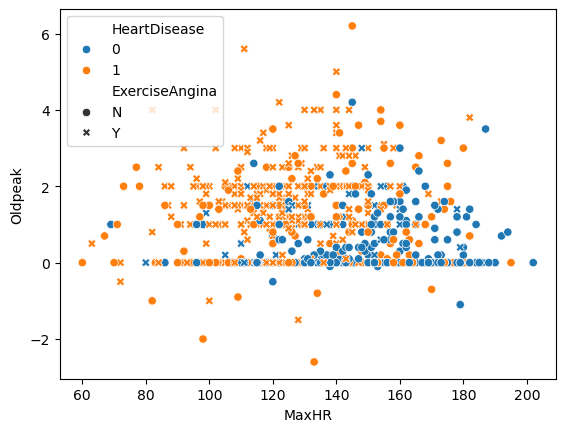

In [9]:
sns.scatterplot(data=data, x='MaxHR', y='Oldpeak', hue='HeartDisease', style='ExerciseAngina')
plt.show()

In [10]:
import scipy.stats as stats

for col in numerical_columns:
    group0 = data[data['HeartDisease'] == 0][col]
    group1 = data[data['HeartDisease'] == 1][col]
    t, p = stats.ttest_ind(group0, group1)
    print(f"{col}: p-value = {p:.4f}")


Age: p-value = 0.0000
RestingBP: p-value = 0.0011
Cholesterol: p-value = 0.0000
MaxHR: p-value = 0.0000
Oldpeak: p-value = 0.0000


**Modelling**

*Preprocessing*

In [11]:
X = data.drop('HeartDisease', axis=1)
y = data['HeartDisease']
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numeric_cols = [col for col in X.columns if col not in categorical_cols]
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [12]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42
    ))
])
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


              precision    recall  f1-score   support

           0       0.88      0.85      0.86        82
           1       0.88      0.90      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



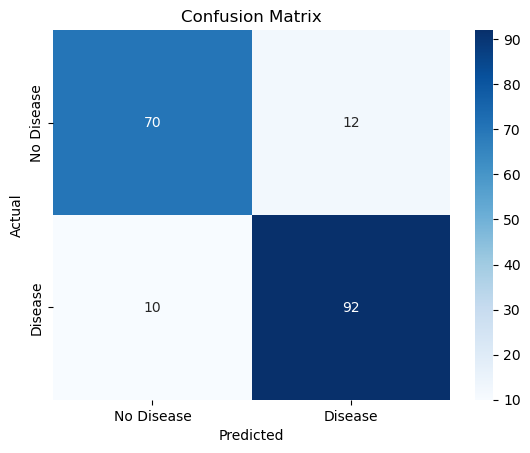

In [13]:

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## XAI

**Feature importances from the random forest model**


,Feature,Importance
8,ST_Slope_Up,0.167062
14,Oldpeak,0.116354
13,MaxHR,0.113704
11,Cholesterol,0.110735
7,ST_Slope_Flat,0.105272
6,ExerciseAngina_Y,0.079531
9,Age,0.076171
10,RestingBP,0.068000
1,ChestPainType_ATA,0.038056
0,Sex_M,0.033209


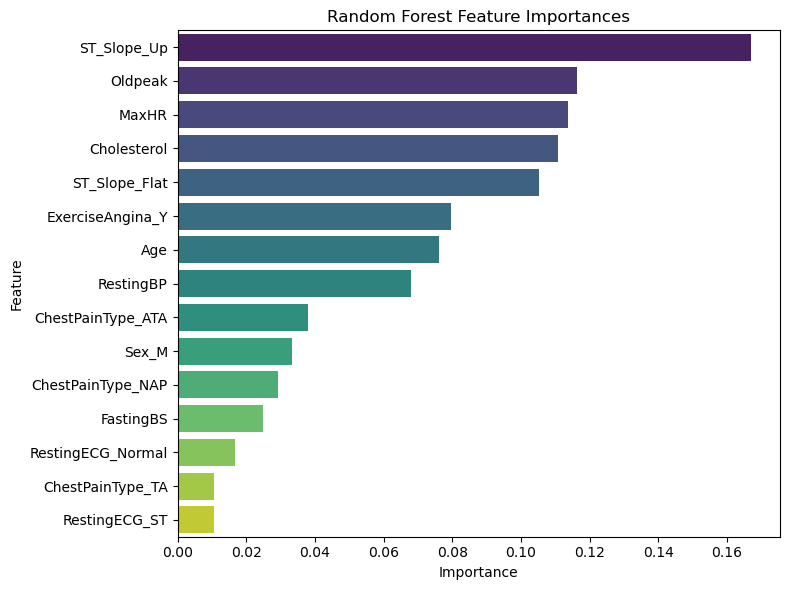

In [14]:
rf = model.named_steps['classifier']
encoder = model.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = encoder.get_feature_names_out(categorical_cols)
all_feature_names = list(cat_feature_names) + numeric_cols
importances = rf.feature_importances_
feat_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)
display(feat_df)
plt.figure(figsize=(8, 6))
sns.barplot(data=feat_df, x='Importance', y='Feature', palette='viridis', hue='Feature', legend=False)
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.show()

**SHAP**


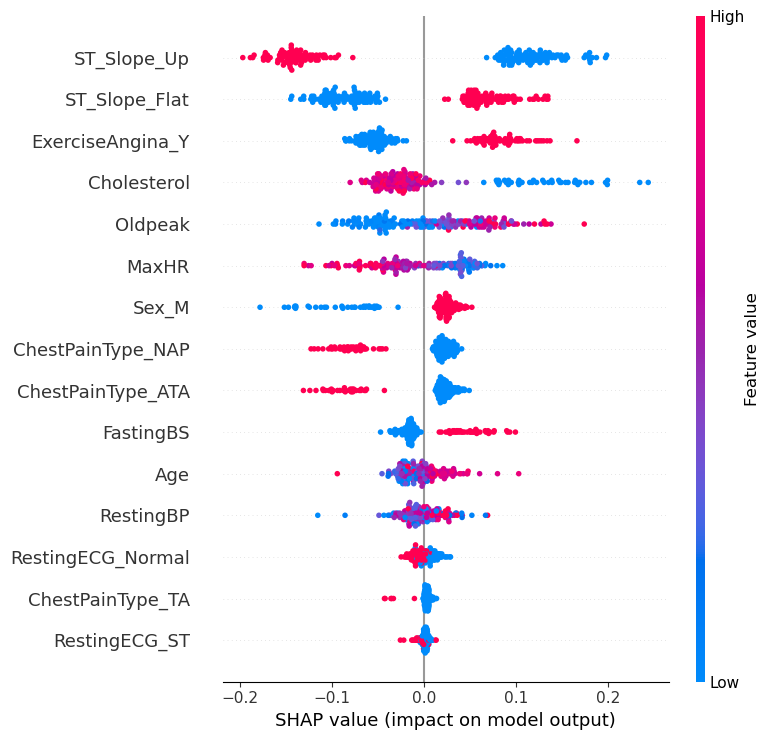

In [15]:
rf = model.named_steps['classifier']
preprocessor = model.named_steps['preprocessor']
encoder = preprocessor.named_transformers_['cat']
cat_feature_names = encoder.get_feature_names_out(categorical_cols)
all_feature_names = list(cat_feature_names) + numeric_cols

X_train_tr = preprocessor.transform(X_train)
X_test_tr = preprocessor.transform(X_test)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_tr)
sv_pos = shap_values[..., 1]
plt.figure()
shap.summary_plot(sv_pos, X_test_tr, feature_names=all_feature_names)

In [16]:
results_df = X_test.copy()
results_df['HeartDisease_true'] = y_test
results_df['HeartDisease_pred'] = y_pred

print("--- Statistical Parity (Demographic Parity) ---")
parity = results_df.groupby('Sex')['HeartDisease_pred'].mean()
print(parity)
statistical_parity_difference = parity['M'] - parity['F']
print(f"\nStatistical Parity Difference (Male - Female): {statistical_parity_difference:.4f}\n")


print("--- Equal Opportunity ---")
true_positives_df = results_df[results_df['HeartDisease_true'] == 1]
opportunity = true_positives_df.groupby('Sex')['HeartDisease_pred'].mean()
print(opportunity)
equal_opportunity_difference = opportunity['M'] - opportunity['F']
print(f"\nEqual Opportunity Difference (Male - Female): {equal_opportunity_difference:.4f}")

--- Statistical Parity (Demographic Parity) ---
Sex
F    0.157895
M    0.671233
Name: HeartDisease_pred, dtype: float64

Statistical Parity Difference (Male - Female): 0.5133

--- Equal Opportunity ---
Sex
F    0.833333
M    0.906250
Name: HeartDisease_pred, dtype: float64

Equal Opportunity Difference (Male - Female): 0.0729
